---

# 도발 시기별 뉴스 기사량 분석 및 시각화
작성자: 현지영, 김지민

이 노트북은 남북한 뉴스 기사의 기사량을 시기별로 집계하고,  
도발 전·후 변화 및 국가별 언론 반응을 시각화하여 분석하는 데 목적이 있습니다.

## 주요 내용
- 폴더 내 CSV 파일 탐색 및 기사 수 집계 (`process_folder`)
- 국가별 + 전체 기사 수를 피벗테이블로 정리 (`summarize_article_counts`)
- 총 기사 수, 국가별 기사 수를 **누적 막대그래프 + 전체 라인그래프**로 시각화
- 각 국가가 전체 기사에서 차지하는 **비율(%)을 텍스트와 함께 시각화**
- 다양한 시각화 함수 제공:
  - `plot_stacked_bar_with_total_line`: 누적 기사 수 + 전체 합 라인 표시
  - `plot_article_stack_with_percentage`: 기사 수 + 비율 텍스트 표시
  - `plot_article_ratio_bar_highlight`: 특정 사건 강조용 바그래프
  - `plot_article_ratio_stack`: 누적 비율 막대그래프
  - `plot_grouped_ratio_stack`: 남북 비교를 위한 그룹형 비율 그래프
  - `plot_article_ratio_stack_by_countries`: 국가별 기준 누적 비율 비교
  - `plot_grouped_ratio_stack_by_countries`: 국가 기준 + 남북 구분 비교

## 출력 결과
- 북한 기사, 남한 기사 각각에 대해 시기별 시각화
- 주요 도발 시기에서 특정 국가 기사량 변화 및 비율 확인 가능

---

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import platform
import seaborn as sns
from matplotlib import font_manager, rc

In [2]:
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    print('Unknown system...')

-----------

## 1. 남북한 기사수 집계 작업

### 폴더 내 기사 수 집계 함수 (`process_folder`)
- 지정한 폴더(`북한기사`, `남한기사`) 내 모든 `*기사_*.csv` 파일을 탐색
- 각 파일의 기사 수(행 수)를 집계하여 `DataFrame`으로 반환
- `"전체"`라는 키워드가 포함된 파일은 전체 기사로 분류, 나머지는 국가별로 분류

In [4]:
def process_folder(folder_path, source_label):
    files = sorted(glob.glob(os.path.join(folder_path, '*기사_*.csv')))
    country = []
    total = []

    for file_path in files:
        filename = os.path.basename(file_path) # 파일 이름 추출

        df = pd.read_csv(file_path)
        row_count = len(df)

        if '전체' in filename:
            total.append({'파일명': filename, '기사수': row_count})
        else:
            country.append({'파일명': filename, '기사수': row_count})

    return pd.DataFrame(country), pd.DataFrame(total)

In [19]:
north_path = 'data/북한기사'
south_path = 'data/남한기사'

df_north_country, df_north_total = process_folder(north_path, '북한')
df_south_country, df_south_total = process_folder(south_path, '남한')

In [20]:
df_north_total.head()

,파일명,기사수
0,10_북한기사_전체.csv,7804
1,11_북한기사_전체.csv,9940
2,12_북한기사_전체.csv,9338
3,13_북한기사_전체.csv,7021
4,14_북한기사_전체.csv,3208


In [21]:
df_north_country.head()

,파일명,기사수
0,10_북한기사_러시아.csv,253
1,10_북한기사_미국.csv,1585
2,10_북한기사_중국.csv,364
3,10_북한기사_한국.csv,3426
4,11_북한기사_러시아.csv,274


------------

## 2. 시각화를 위한 기사수 피벗테이블 생성

### 국가별 기사 수 + 전체 기사 수를 집계해서 피벗 형태로 정리하는 함수(`summarize_article_counts`)
- 국가별 기사 파일명(`예: 1_남한기사_미국.csv`)에서 기사 번호와 국가명을 추출
- str.extract(...): 문자열에서 정규식에 해당하는 부분만 추출해주는 함수
- 각 국가별 기사 수를 기준으로 **피벗 테이블** 형태로 집계
- 전체 기사 수(`*_전체.csv`)를 합쳐 하나의 행 기준으로 정리
- 기사 번호를 기준으로 정렬 처리

In [8]:
def summarize_article_counts(df_country, df_total, prefix, countries):
    df_country = df_country.copy()
    
    # 파일명에서 기사 ID 추출 (예: 1_북한기사_미국.csv → 1_북한기사)
    df_country['기사'] = df_country['파일명'].str.extract(fr'(\d+_{prefix})')

    # 파일명에서 국가명 추출 (예: 1_북한기사_미국.csv → 미국)
    df_country['국가'] = df_country['파일명'].str.extract(fr'{prefix}_(.+)\.csv') # 괄호 안에 들어간 것만 추출

    # 피벗 테이블 생성: 기사 ID를 인덱스로, 국가명을 컬럼으로 기사 수 집계
    pivot_df = df_country.pivot_table(
        index='기사',
        columns='국가',
        values='기사수',
        aggfunc='sum',
        fill_value=0
    ).astype(int)

    df_total = df_total.copy()
    df_total['기사'] = df_total['파일명'].str.extract(fr'(\d+_{prefix})')

    # 전체 기사 수를 merge하여 '전체' 컬럼으로 추가
    pivot_df = pivot_df.merge(df_total[['기사', '기사수']], on='기사', how='left')
    pivot_df = pivot_df.rename(columns={'기사수': '전체'})

    # 인덱스를 기사 ID로 설정하고, 숫자 기준으로 정렬
    pivot_df = pivot_df.set_index('기사')
    pivot_df.index = pivot_df.index.astype(str)
    pivot_df = pivot_df.sort_index(key=lambda x: x.str.extract(r'^(\d+)', expand=False).astype(int))

    return pivot_df

In [25]:
south_columns = ['미국', '중국', '러시아', '북한']
pivot_south = summarize_article_counts(
    df_country = df_south_country, 
    df_total = df_south_total, 
    prefix = '남한기사', 
    countries = south_columns
)

north_columns = ['미국', '중국', '러시아', '한국']
pivot_north = summarize_article_counts(
    df_country = df_north_country, 
    df_total = df_north_total, 
    prefix = '북한기사', 
    countries = north_columns
)

In [26]:
pivot_north.head()

,러시아,미국,중국,한국,전체
기사,,,,,
1_북한기사,40,69,30,116,844
2_북한기사,28,72,44,85,956
3_북한기사,21,86,28,200,1045
4_북한기사,21,70,18,151,863
5_북한기사,16,68,90,136,1037


-------------

## 3. 남북한 기사수 시각화

### 1) 기사 수 시각화 함수 (`plot_stacked_bar_with_total_line`)

- `국가별` 기사 수를 **누적 막대그래프** 형태로 시각화
- `전체` 기사 수는 **꺾은선 그래프**로 함께 표시 (우측 y축 사용)
- `pivot_north`, `pivot_south`의 피벗 테이블을 기반으로 시각화 가능
- `twinx()`를 사용해 국가별 기사 수와 전체 기사 수를 함께 표시

In [156]:
def plot_stacked_bar_with_total_line(df, countries, title):
    x = df.index.tolist()                     # x축 라벨 (기사 번호)
    bottom = [0] * len(df)                    # 누적 막대 초기값 (맨 아래 높이: 0부터 시작)

    fig, ax1 = plt.subplots(figsize=(14, 6))  # 첫 번째 y축을 위한 subplot 생성

    colors = sns.color_palette("tab10", n_colors=len(countries))  

    # 누적 막대 그래프 (국가별 기사 수)
    for idx, country in enumerate(countries):
        ax1.bar(
            x, df[country], bottom=bottom,    # 누적 기준 위에 쌓기
            label=country, color=colors[idx]
        )
        bottom = [i + j for i, j in zip(bottom, df[country])]  # 다음 막대에 쌓을 기준 업데이트



    # 전체 기사 수 선 그래프 (두 번째 y축)
    ax2 = ax1.twinx() # ax1과 x축은 같고, y축만 오른쪽에 추가된 축
    ax2.plot(x, df['전체'], color='black', linestyle='--', marker='o', label='전체', linewidth=2)

    # 그래프 설정
    ax1.set_ylabel("국가별 기사 수(건)")
    ax2.set_ylabel("전체 기사 수(건)")
    event_labels = [
        '제2연평해전', '북한1차핵실험', '북한2차핵실험', '천안함피격', '연평도포격',
        '북한3차핵실험', '동해안단거리미사일', 'DMZ목함지뢰매설', '북한4차핵실험',
        '북한5차핵실험', '북한6차핵실험', '신형탄도미사일', 'NLL이남대륙간탄도미사일',
        '오물풍선', '평온시기'
    ]
    ax1.set_xticks(range(len(event_labels)))
    ax1.set_xticklabels(event_labels, rotation=90)
    fig.suptitle(title, fontsize=14)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    
    # 범례 설정 (좌우 y축 통합)
    handles1, labels1 = ax1.get_legend_handles_labels() # label1 = 미국, 중국, 러시아 ...
    handles2, labels2 = ax2.get_legend_handles_labels() # label2 = 전체
    ax1.legend(handles1 + handles2, labels1 + labels2, title="국가")

    plt.tight_layout()
    plt.show()

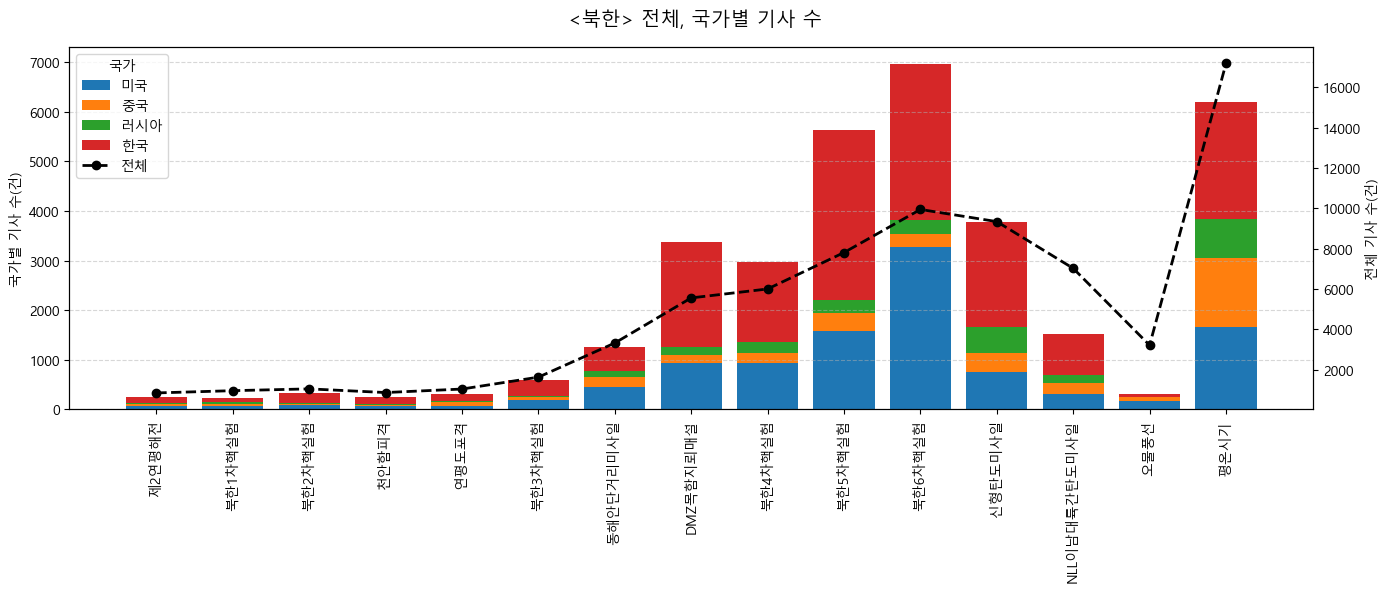

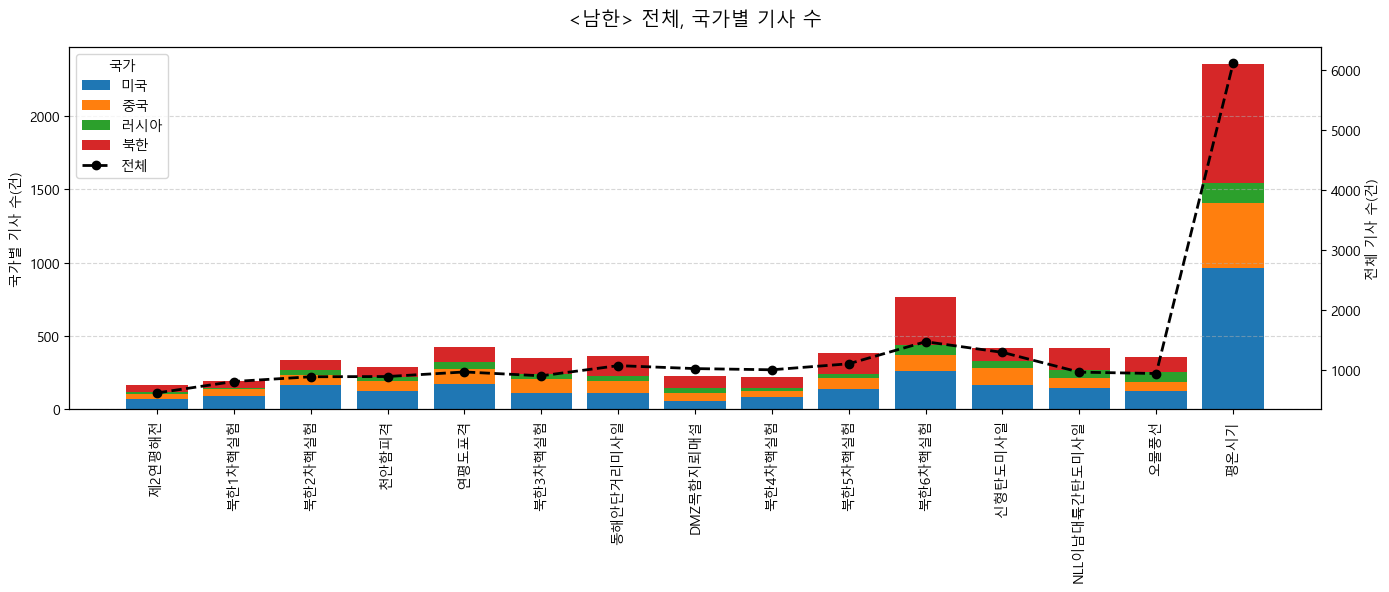

In [157]:
# 북한 기사 시각화
plot_stacked_bar_with_total_line(
    df=pivot_north,
    countries=['미국', '중국', '러시아', '한국'],
    title="<북한> 전체, 국가별 기사 수"
)

# 남한 기사 시각화
plot_stacked_bar_with_total_line(
    df=pivot_south,
    countries=['미국', '중국', '러시아', '북한'],
    title="<남한> 전체, 국가별 기사 수"
)

### 2) 기사 수 + 비율 표시 시각화 함수 (`plot_article_stack_with_percentage`)

- 국가별 기사 수를 **누적 막대그래프**로 시각화
- 각 국가가 해당 기사에서 차지하는 **비율(%)을 막대 위에 함께 표시**

In [154]:
def plot_article_stack_with_percentage(pivot_df, title):
    df = pivot_df.copy()
    countries = df.columns.drop('전체')        # 국가별 컬럼만 추출
    total = df['전체']                         # 전체 기사 수
    x = np.arange(len(df))                    # x축 위치
    width = 0.6                               

    colors = sns.color_palette("tab10", n_colors=len(countries))

    plt.figure(figsize=(14, 6))
    bottom = np.zeros(len(df))               # 각 막대의 누적 시작점 (맨 밑부터 쌓음)

    for idx, country in enumerate(countries): # 국가별로 한 번에 그리기
        heights = df[country].values # 해당 국가 기사수
        
        # 누적 막대 그리기
        plt.bar( 
            x, heights, bottom=bottom,
            width=width, color=colors[idx], label=country
        )

        # 모든 비율 텍스트 표시
        for i, (h, b, t) in enumerate(zip(heights, bottom, total)):
            if h > 0:
                percent = h / t * 100
                plt.text(
                    x[i], b + h / 2,
                    f"{percent:.1f}%", ha='center', va='center',
                    fontsize=10, color='black'
                )
                
        bottom += heights # 누적 기준 업데이트

    event_labels = [
        '제2연평해전', '북한1차핵실험', '북한2차핵실험', '천안함피격', '연평도포격',
        '북한3차핵실험', '동해안단거리미사일', 'DMZ목함지뢰매설', '북한4차핵실험',
        '북한5차핵실험', '북한6차핵실험', '신형탄도미사일', 'NLL이남대륙간탄도미사일',
        '오물풍선', '평온시기'
    ]
    plt.xticks(x, event_labels, rotation=90)
    plt.ylabel("기사 수(건)")
    plt.title(f"{title} - 국가별 기사 수 (비율 포함)")
    plt.legend(title="국가", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

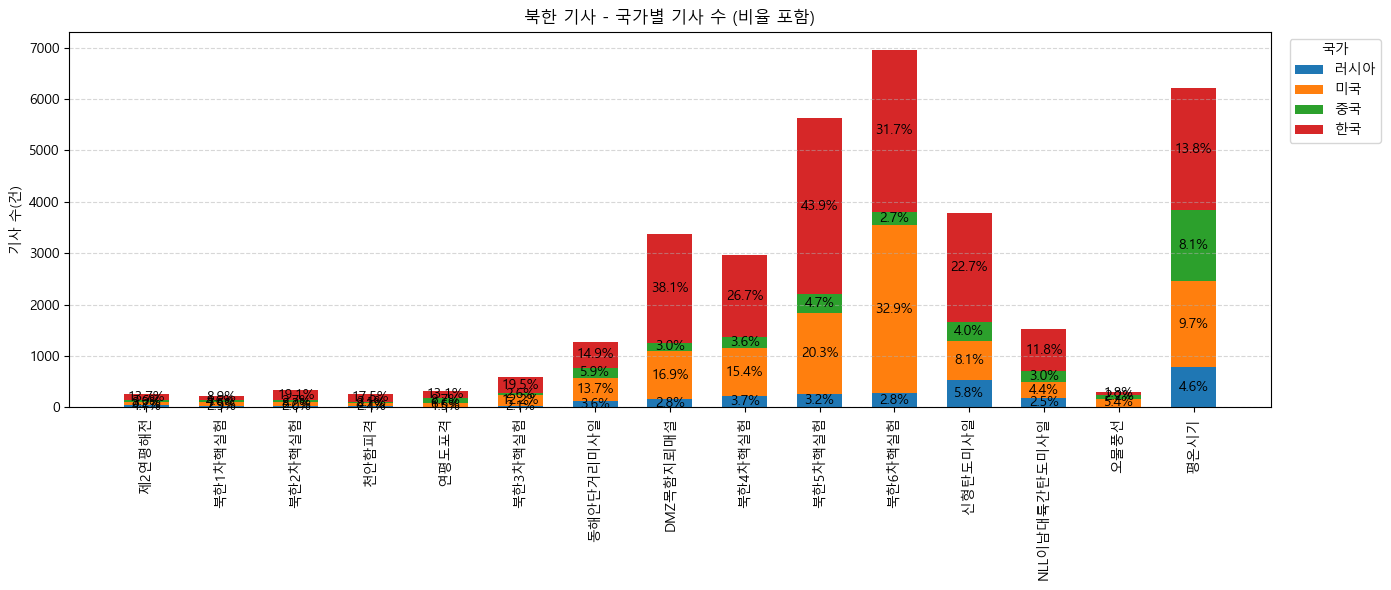

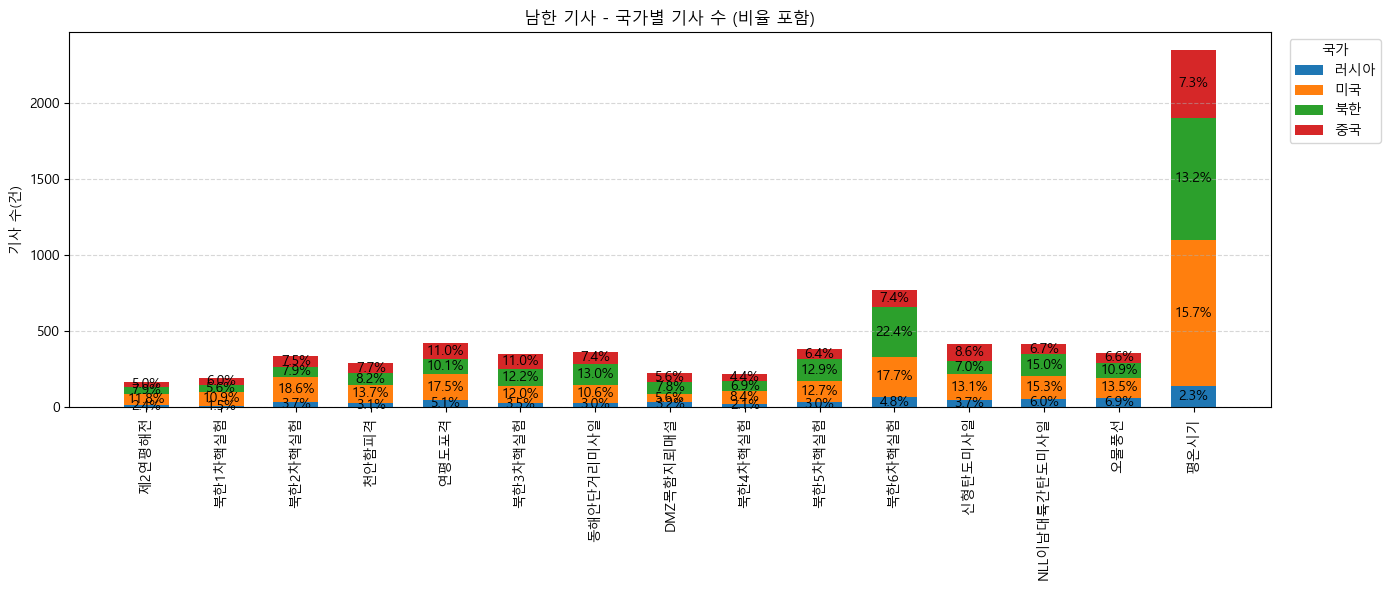

In [155]:
plot_article_stack_with_percentage(pivot_north, '북한 기사')
plot_article_stack_with_percentage(pivot_south, '남한 기사')

### 3) 전체 대비 국가별 기사 비율 시각화 함수 (`plot_article_ratio_bar_highlight`)

- 각 기사에서 국가별 기사수를 `'전체'` 대비 **비율(%)로 정규화**
- **누적 비율 막대그래프**로 시각화하고, **특정 기사를**의 경우 바 너비를 넓게 표시
- `highlight_article` 인자로 `'15_북한기사'`, `'15_남한기사'`강조 표시

In [32]:
def plot_article_ratio_bar_highlight(pivot_df, title, highlight_article):
    # 전체 대비 비율로 변환
    df = pivot_df.copy()
    total = df['전체']
    df = df.drop(columns='전체')
    df = df.div(total, axis=0)  # 전체 기준으로 나눠 비율로 변환

    countries = df.columns.tolist()
    colors = sns.color_palette("tab10", n_colors=len(countries))

    x = np.arange(len(df))            # 기사 개수만큼 x 위치 설정
    width = 0.6                       # 기본 막대 너비
    highlight_width = 1.2             # 강조할 막대는 더 두껍게

    bottom = np.zeros(len(df))        # 누적 막대 초기화

    plt.figure(figsize=(14, 6))

    # 국가별 누적 비율 막대그래프
    for idx, country in enumerate(countries):
        heights = df[country].values

        for i in range(len(df)): # 기사별로 따로 그리기
            bar_width = (
                highlight_width if df.index[i] in highlight_article else width
            )

            plt.bar(
                x[i], heights[i],
                bottom=bottom[i],
                width=bar_width,
                color=colors[idx],
                label=country if i == 0 else "",  # 범례가 중복되지 않게 각 국가는 한 번만
                edgecolor='none'
            )

        bottom += heights  # 다음 국가 누적 기준 업데이트

    event_labels = [
        '제2연평해전', '북한1차핵실험', '북한2차핵실험', '천안함피격', '연평도포격',
        '북한3차핵실험', '동해안단거리미사일', 'DMZ목함지뢰매설', '북한4차핵실험',
        '북한5차핵실험', '북한6차핵실험', '신형탄도미사일', 'NLL이남대륙간탄도미사일',
        '오물풍선', '평온시기'
    ]
    plt.xticks(x, event_labels, rotation=90)
    plt.ylim(0, 1.05)
    plt.ylabel("전체 대비 비율")
    plt.title(f"{title} - 국가별 기사 비율")
    plt.legend(title="국가", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

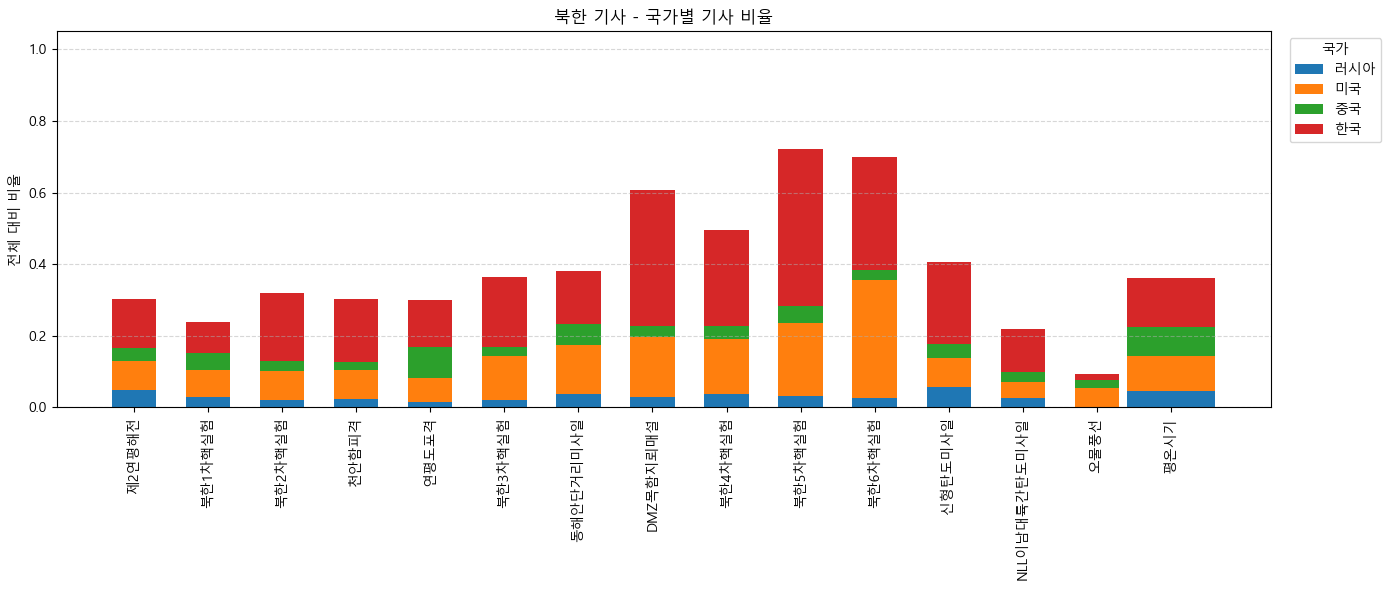

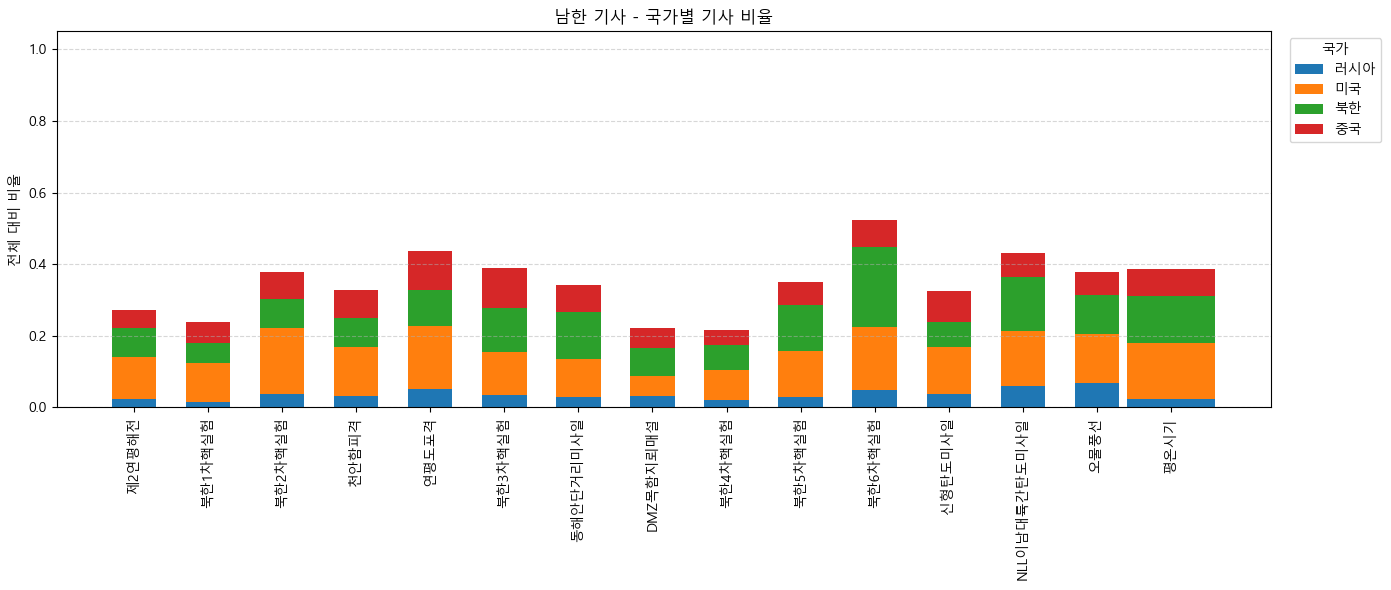

In [33]:
plot_article_ratio_bar_highlight(pivot_north, '북한 기사', highlight_article=['15_북한기사'])
plot_article_ratio_bar_highlight(pivot_south, '남한 기사', highlight_article=['15_남한기사'])

### 4) 전체 대비 국가별 기사 비율 시각화 함수2 (`plot_article_ratio_stack`)

- 각 사건별로 국가별 기사 수를 `'전체'` 기사 수 대비 **비율(%)로 정규화**
- 정규화된 비율을 **누적 비율 막대그래프**로 시각화하고, 각 비율을 **텍스트로 표시**
- x축은 `사건명`, y축은 `0~100%`, 범례는 `국가` 기준

In [158]:
def plot_article_ratio_stack(pivot_df, title):
    df = pivot_df.copy()
    countries = df.columns.drop('전체')        # 국가별 컬럼만 추출
    total = df['전체']                         # 전체 기사 수
    x = np.arange(len(df))                    # x축 위치
    width = 0.6                               

    colors = sns.color_palette("tab10", n_colors=len(countries))

    plt.figure(figsize=(14, 6))
    bottom = np.zeros(len(df))               # 각 막대의 누적 시작점 (맨 밑부터 쌓음)

    for idx, country in enumerate(countries): # 국가별로 한 번에 그리기
        count_x = df[country].values # 해당 국가 기사수
        heights = count_x/total * 100  # 해당 국가 기사수 비율
        
        # 누적 막대 그리기
        plt.bar( 
            x, heights, bottom=bottom,
            width=width, color=colors[idx], label=country
        )

        # 각 비율 텍스트 표시
        for i, (b, h) in enumerate(zip(bottom, heights)):
            if h > 0:
                plt.text(
                    x[i], b + h / 2, f"{h:.1f}%", 
                    ha='center', va='center', fontsize=10, color='black'
                )
                
        bottom += heights # 누적 기준 업데이트

    event_labels = [
        '제2연평해전', '북한1차핵실험', '북한2차핵실험', '천안함피격', '연평도포격',
        '북한3차핵실험', '동해안단거리미사일', 'DMZ목함지뢰매설', '북한4차핵실험',
        '북한5차핵실험', '북한6차핵실험', '신형탄도미사일', 'NLL이남대륙간탄도미사일',
        '오물풍선', '평온시기'
    ]
    plt.xticks(x, event_labels, rotation=90)
    plt.ylim(0, 100)
    plt.ylabel("기사 수 비율(%)")
    plt.title(f"{title} - 국가별 기사 수 비율 (전체 기사 기준)")
    plt.legend(title="국가", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

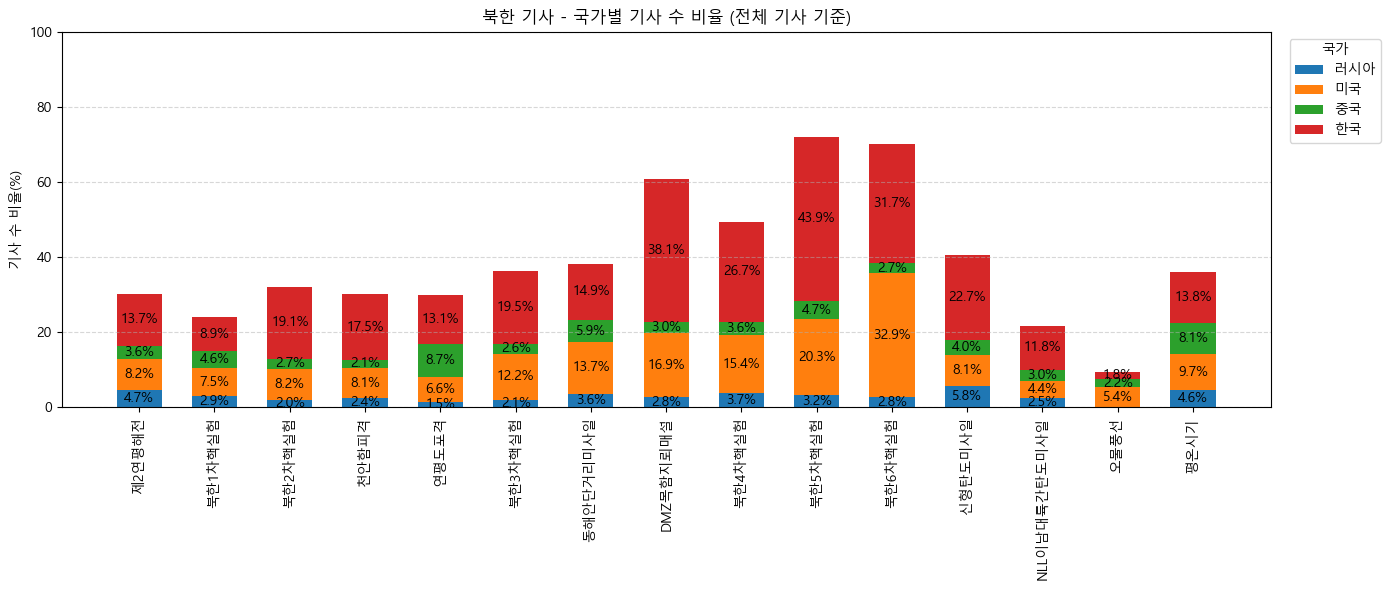

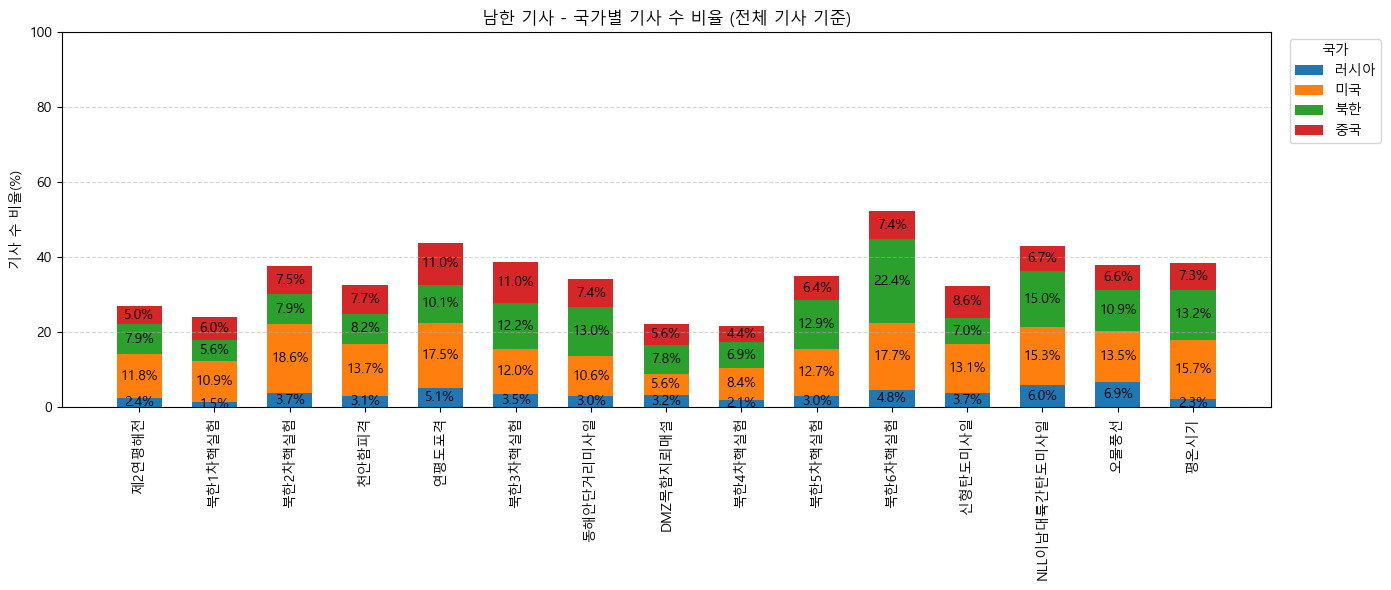

In [159]:
plot_article_ratio_stack(pivot_north, '북한 기사')
plot_article_ratio_stack(pivot_south, '남한 기사')

### 5) 전체 대비 국가별 기사 비율 출처 나라별 시각화 함수 (`plot_grouped_ratio_stack`)

- 각 사건별로 국가별 기사 수를 `'전체'` 기사 수 대비 **비율(%)로 정규화**
- 정규화된 비율을 **누적 비율 막대그래프**로 시각화
- **남한과 북한 출처 기사 데이터를 한 그래프에 나란히 시각화**하여 비교
- 북한막애에는 **빗금(`hatch='///'`)을 적용**해 시각적으로 구분

In [152]:
def plot_grouped_ratio_stack(pivot_south, pivot_north):
    df_south = pivot_south.copy()
    df_north = pivot_north.copy()

    # 인덱스를 1~15 숫자로 통일
    df_south.index = list(range(1, len(df_south) + 1))
    df_north.index = list(range(1, len(df_north) + 1))

    countries_s = df_south.columns.drop('전체')
    countries_n = df_north.columns.drop('전체')

    # 전체 기사 수
    total_s = df_south['전체']
    total_n = df_north['전체']                           

    x = np.arange(len(df_south))*2.2
    width = 0.5  

    colors = sns.color_palette("tab10", n_colors=max(len(countries_s), len(countries_n)))

    plt.figure(figsize=(18, 6))

    # 남한 (왼쪽 막대)
    bottom = np.zeros(len(df_south))
    for idx, country in enumerate(countries_s):
        heights = df_south[country] / total_s * 100
        plt.bar(x - width, heights, bottom=bottom, width=width, color=colors[idx], label=f"남한 - {country}")
        bottom += heights

    # 북한 (오른쪽 막대)
    bottom = np.zeros(len(df_north))
    for idx, country in enumerate(countries_n):
        heights = df_north[country] / total_n * 100
        plt.bar(x + width, heights, bottom=bottom, width=width, color=colors[idx], label=f"북한 - {country}", hatch='///')
        bottom += heights

    # x축 라벨
    event_labels = [
        '제2연평해전', '북한1차핵실험', '북한2차핵실험', '천안함피격', '연평도포격',
        '북한3차핵실험', '동해안단거리미사일', 'DMZ목함지뢰매설', '북한4차핵실험',
        '북한5차핵실험', '북한6차핵실험', '신형탄도미사일', 'NLL이남대륙간탄도미사일',
        '오물풍선', '평온시기'
    ]
    plt.xticks(x, event_labels, rotation=90)

    plt.ylim(0, 100)
    plt.ylabel("기사 수 비율(%)")
    plt.title(f"남한/북한 출처 기사에 대한 국가별 기사 수 비율 (전체 기사 기준)")
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='구분(기사출처 - 검색어)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

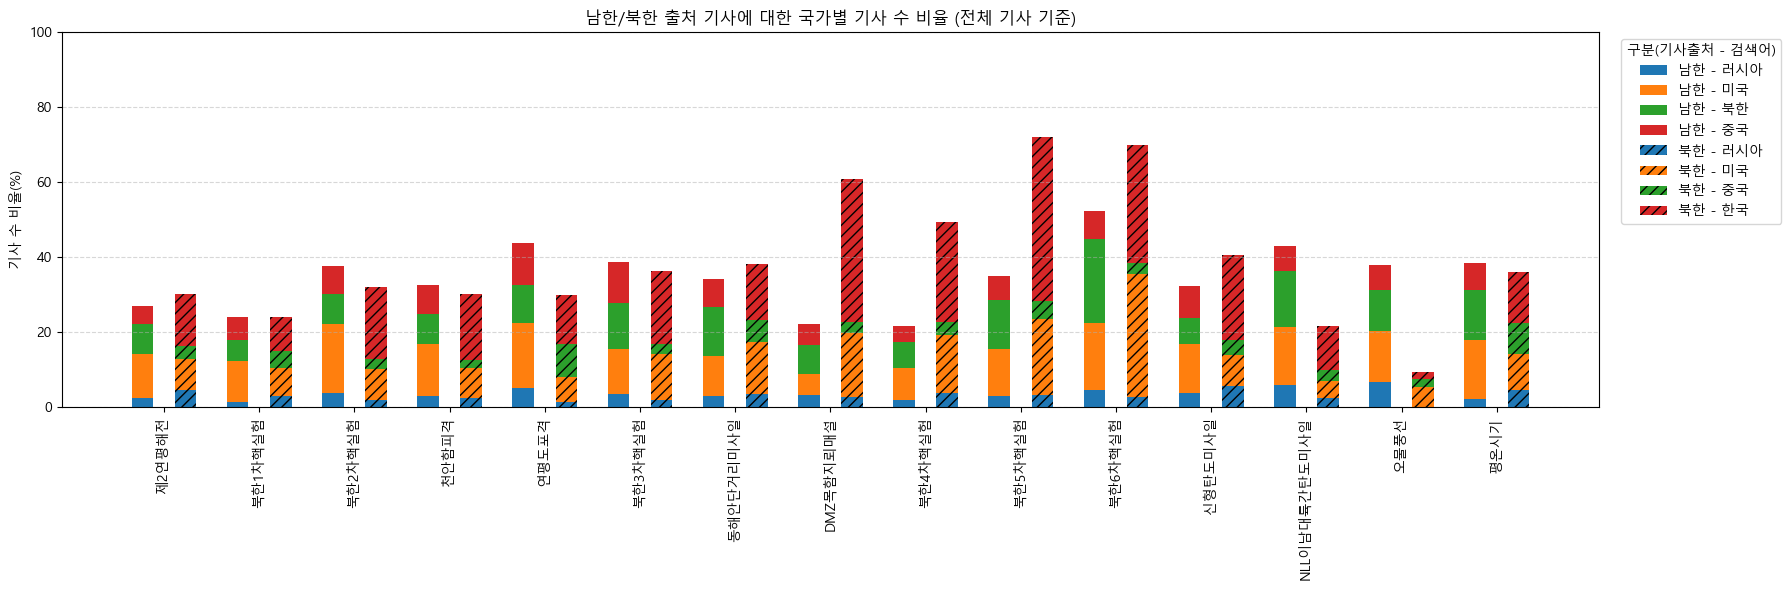

In [153]:
plot_grouped_ratio_stack(pivot_south, pivot_north)

### 6) 국가별 기사 비율 시각화 함수 (`plot_article_ratio_stack_by_countries`)

- 각 사건별로 국가별 기사 수를 `'국가별 기사 수의 총 합'` 대비 **비율(%)로 정규화**
- 정규화된 비율을 **누적 비율 막대그래프**로 시각화하고, 각 비율을 **텍스트로 표시**
- x축은 `사건명`, y축은 `0~100%`, 범례는 `국가` 기준

In [160]:
def plot_article_ratio_stack_by_countries(pivot_df, title):
    df = pivot_df.copy()
    countries = df.columns.drop('전체')        # 국가별 컬럼만 추출
    total = df[countries].sum(axis=1)          # 모든 국가별 기사 수 합계를 행 단위로 계산
    x = np.arange(len(df))                    # x축 위치
    width = 0.6                               

    colors = sns.color_palette("tab10", n_colors=len(countries))

    plt.figure(figsize=(14, 6))
    bottom = np.zeros(len(df))               # 각 막대의 누적 시작점 (맨 밑부터 쌓음)

    for idx, country in enumerate(countries): # 국가별로 한 번에 그리기
        count_x = df[country].values # 해당 국가 기사수
        heights = count_x/total * 100  # 해당 국가 기사수 비율
        
        # 누적 막대 그리기
        plt.bar( 
            x, heights, bottom=bottom,
            width=width, color=colors[idx], label=country
        )

        # 각 비율 텍스트 표시
        for i, (b, h) in enumerate(zip(bottom, heights)):
            if h > 0:
                plt.text(
                    x[i], b + h / 2, f"{h:.1f}%", 
                    ha='center', va='center', fontsize=10, color='black'
                )
                
        bottom += heights # 누적 기준 업데이트

    event_labels = [
        '제2연평해전', '북한1차핵실험', '북한2차핵실험', '천안함피격', '연평도포격',
        '북한3차핵실험', '동해안단거리미사일', 'DMZ목함지뢰매설', '북한4차핵실험',
        '북한5차핵실험', '북한6차핵실험', '신형탄도미사일', 'NLL이남대륙간탄도미사일',
        '오물풍선', '평온시기'
    ]
    plt.xticks(x, event_labels, rotation=90)
    plt.ylim(0, 100)
    plt.ylabel("기사 수 비율(%)")
    plt.title(f"{title} - 국가별 기사 수 비율 (국가별 기사 총 합 기준)")
    plt.legend(title="국가", bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

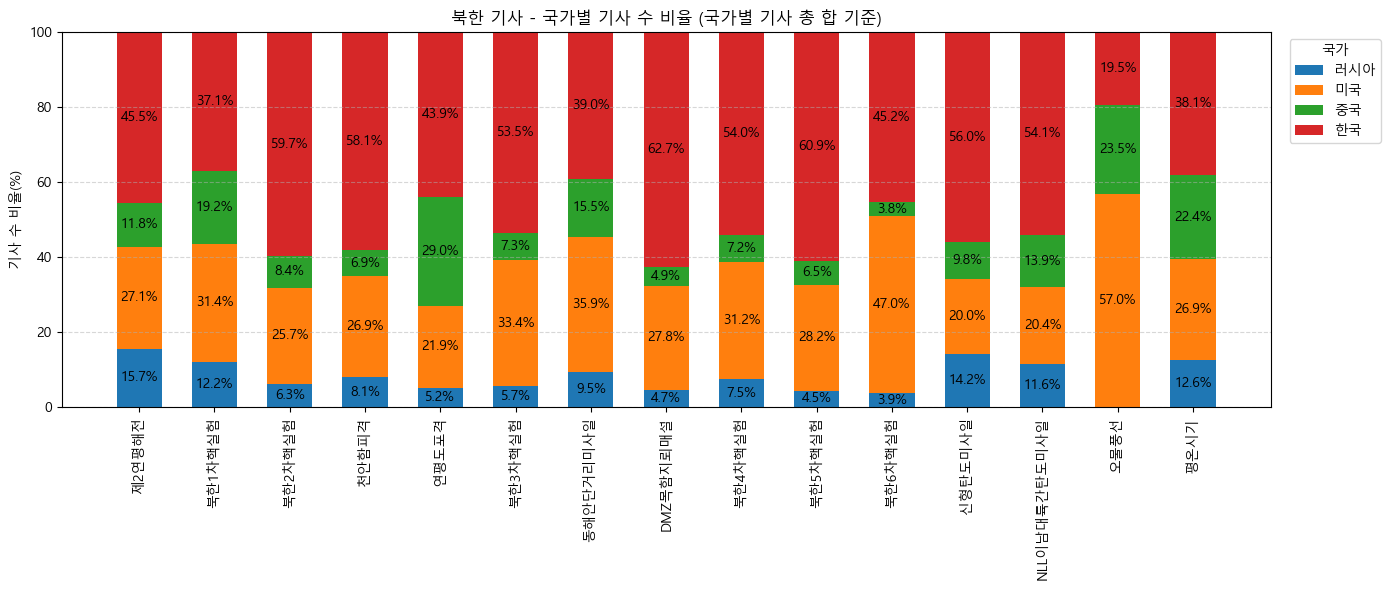

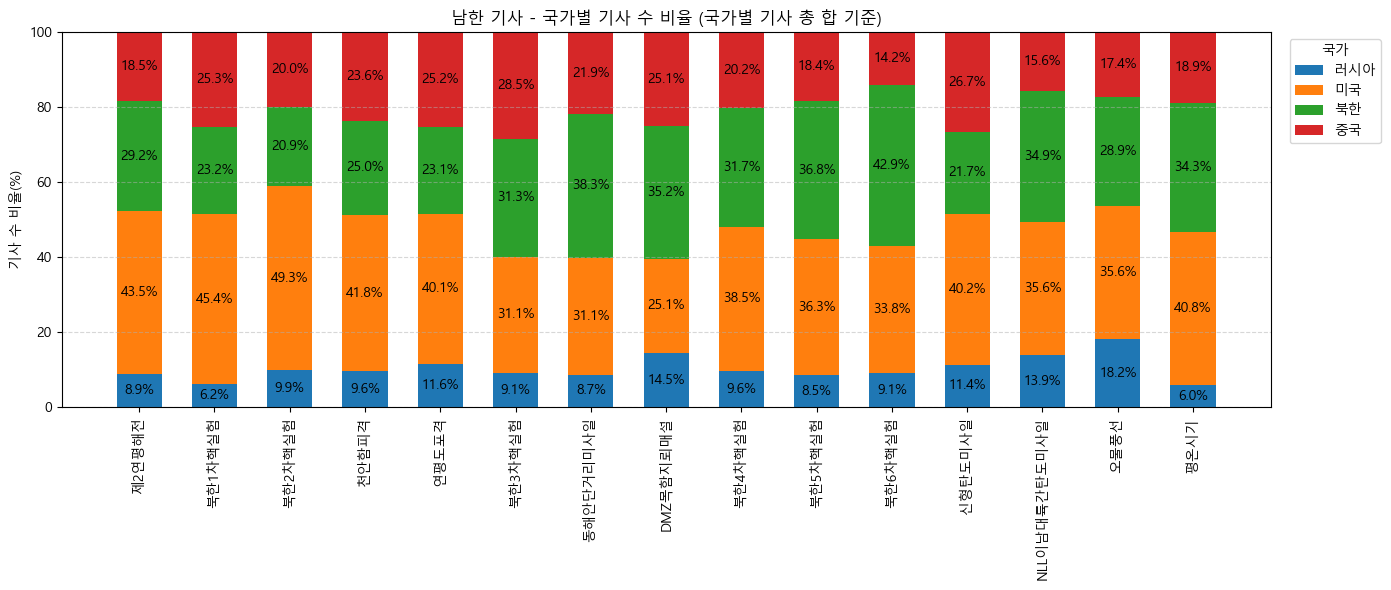

In [161]:
plot_article_ratio_stack_by_countries(pivot_north, '북한 기사')
plot_article_ratio_stack_by_countries(pivot_south, '남한 기사')

### 7) 국가별 기사 비율 출처 나라별 시각화 함수 (`plot_grouped_ratio_stack_by_countries`)

- 각 사건별로 국가별 기사 수를 `'국가별 기사 수의 총 합'` 대비 **비율(%)로 정규화**
- 정규화된 비율을 **누적 비율 막대그래프**로 시각화하고, 각 비율을 **텍스트로 표시**
- **남한과 북한 출처 기사 데이터를 한 그래프에 나란히 시각화**하여 비교
- 북한막애에는 **빗금(`hatch='///'`)을 적용**해 시각적으로 구분

In [148]:
def plot_grouped_ratio_stack_by_countries(pivot_south, pivot_north):
    df_south = pivot_south.copy()
    df_north = pivot_north.copy()

    # 인덱스를 1~15 숫자로 통일
    df_south.index = list(range(1, len(df_south) + 1))
    df_north.index = list(range(1, len(df_north) + 1))

    countries_s = df_south.columns.drop('전체')
    countries_n = df_north.columns.drop('전체')

    # 전체 기사 수 직접 계산
    total_s = df_south[countries_s].sum(axis=1)
    total_n = df_north[countries_n].sum(axis=1)

    x = np.arange(len(df_south)) * 2  # ✅ 사건 간 간격 확보
    width = 0.5  # ✅ 막대 두께 키우기

    colors = sns.color_palette("tab10", n_colors=max(len(countries_s), len(countries_n)))

    plt.figure(figsize=(18, 6))

    # 남한 (왼쪽 막대)
    bottom = np.zeros(len(df_south))
    for idx, country in enumerate(countries_s):
        heights = df_south[country] / total_s * 100
        plt.bar(x - width, heights, bottom=bottom, width=width, color=colors[idx], label=f"남한 - {country}")
        # 각 비율 텍스트 표시
        for i, (b, h) in enumerate(zip(bottom, heights)):
            if h > 0:
                plt.text(
                    x[i]-width, b + h / 2, f"{h:.1f}%", 
                    ha='center', va='center', fontsize=11, color='black'
                )
        bottom += heights

    # 북한 (오른쪽 막대)
    bottom = np.zeros(len(df_north))
    for idx, country in enumerate(countries_n):
        heights = df_north[country] / total_n * 100
        plt.bar(x + width, heights, bottom=bottom, width=width, color=colors[idx], label=f"북한 - {country}", hatch='///')
        # 각 비율 텍스트 표시
        for i, (b, h) in enumerate(zip(bottom, heights)):
            if h > 0:
                plt.text(
                    x[i]+width, b + h / 2, f"{h:.1f}%", 
                    ha='center', va='center', fontsize=11, color='black'
                )
        bottom += heights

    # x축 라벨
    event_labels = [
        '제2연평해전', '북한1차핵실험', '북한2차핵실험', '천안함피격', '연평도포격',
        '북한3차핵실험', '동해안단거리미사일', 'DMZ목함지뢰매설', '북한4차핵실험',
        '북한5차핵실험', '북한6차핵실험', '신형탄도미사일', 'NLL이남대륙간탄도미사일',
        '오물풍선', '평온시기'
    ]
    plt.xticks(x, event_labels, rotation=90)

    plt.ylim(0, 100)
    plt.ylabel("기사 수 비율(%)")
    plt.title(f"남한/북한 출처 기사에 대한 국가별 기사 수 비율 (국가별 기사 총 합 기준)")
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', title='구분(기사출처 - 검색어)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

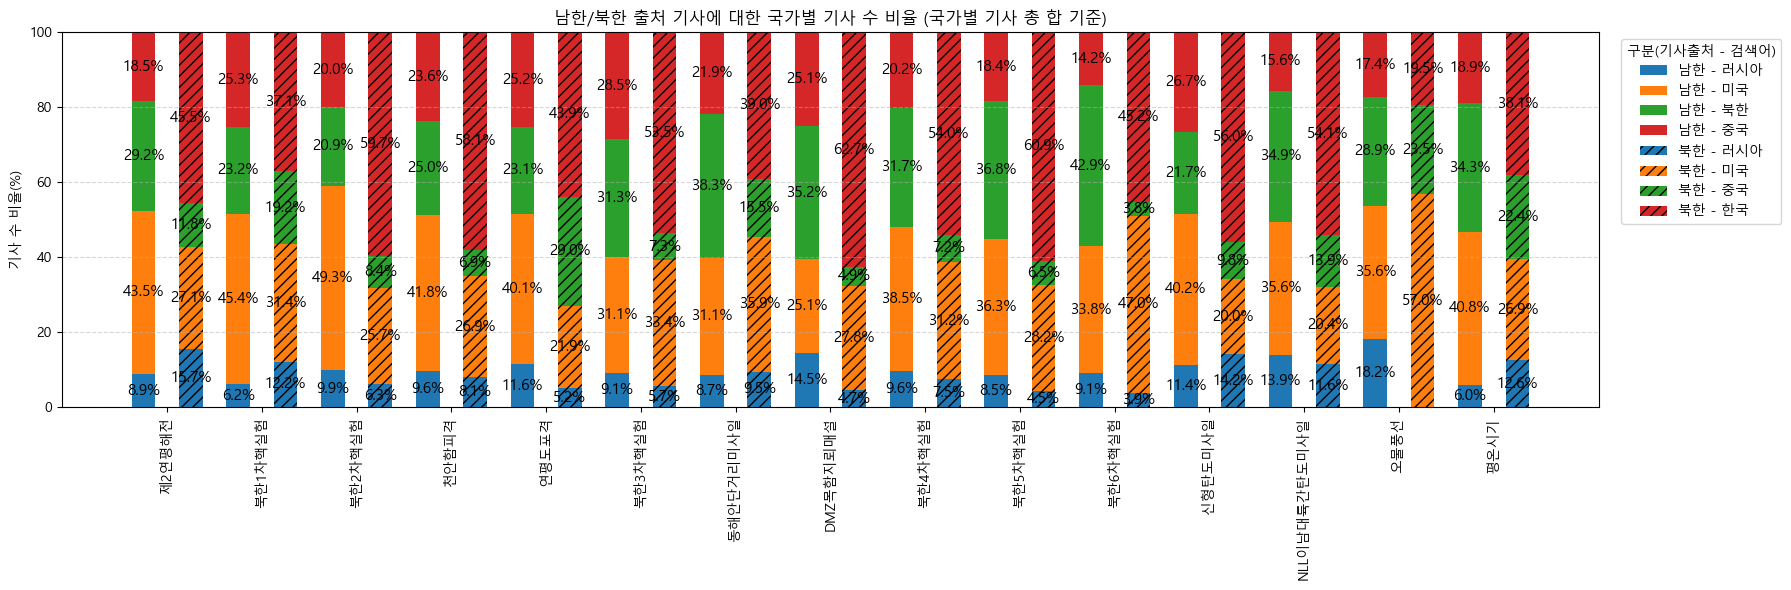

In [149]:
plot_grouped_ratio_stack_by_countries(pivot_south, pivot_north)

-------